In [4]:
from qutip import *
from scipy.optimize import minimize
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
from supports import *
from plotsettings import *

In [7]:
# Device 
Nq = 10         # number of levels in qubit
Nc = 10         # number of levels in resonator 1
wc = 4.0928  # bare resonator frequency
anh_meas = 0.15  # dressed anharmonicity
# wq = 6.811  # bare resonator frequency

wq_dressed_meas = 6.811
wc_dressed_meas = 4.0753

wq_list  = np.linspace(6.7, 6.9, 21)
g_list = np.linspace(0.16, 0.19, 31)
Ec_list = np.linspace(0.13, 0.16, 31)

b = tensor(destroy(Nq), qeye(Nc))
a = tensor(qeye(Nc), destroy(Nq))
nq = b.dag()*b
nc = a.dag()*a

In [12]:
wq_dressed = np.zeros((len(wq_list), len(g_list), len(Ec_list)))
wc_dressed = np.zeros((len(wq_list), len(g_list), len(Ec_list)))
anharmonicity = np.zeros((len(wq_list), len(g_list), len(Ec_list)))

for i, wq in enumerate(wq_list):
    for j, g in enumerate(g_list):
        for k, Ec in enumerate(Ec_list):
            Hi = (wq+Ec)*nq + wc*nc - Ec/12*(b + b.dag())**4  # intrinsic
            Hc = g*(a + a.dag())*(b + b.dag())  # coupling
            EE = (Hi+Hc).eigenenergies()
            wc_dressed[i][j][k] = EE[1]-EE[0]
            wq_dressed[i][j][k] = EE[2]-EE[0]
            anharmonicity[i][j][k] = 2*(EE[2]-EE[0])-(EE[6]-EE[0])

In [84]:
wq_dressed_squared = np.multiply((wq_dressed-wq_dressed_meas), (wq_dressed-wq_dressed_meas))
wc_dressed_squared = np.multiply((wc_dressed-wc_dressed_meas), (wc_dressed-wc_dressed_meas))
anharmonicity_squared = np.multiply((anharmonicity-0.15), (anharmonicity-0.15))
diffs =  wq_dressed_squared + wc_dressed_squared + anharmonicity_squared

In [85]:
I, J, K = np.unravel_index(np.argmin(diffs, axis=None), diffs.shape)
wq = wq_list[I]
# J, K = np.unravel_index(np.argmin(diffs, axis=None), diffs.shape)
g = g_list[J]
Ec = Ec_list[K]
print(wq)
print(g)
print(Ec)

6.8100000000000005
0.185
0.138


In [8]:
wq = 6.8
g = 0.2
Ec = 0.15

_wq_list = list()
_g_list = list()
_Ec_list = list()

In [45]:
Hi = (wq+Ec)*nq + wc*nc - Ec/12*(b + b.dag())**4  # intrinsic
Hc = g*(a + a.dag())*(b + b.dag())  # coupling
EE = (Hi+Hc).eigenenergies()
print(EE - EE[0])

[ 0.          4.07393709  6.8038832   8.14786132 10.87477561 12.22177265
 13.44387625 14.94564239 16.29567101 17.5106464  19.01648336 19.90778872
 20.36955635 21.57736561 23.08729835 23.968877   24.44342861 25.6440337
 26.1836507  27.15808718 28.02989973 28.51728893 29.71065054 30.23825031
 31.22884969 32.09086268 32.27878279 32.59140542 33.77721602 34.29315367
 35.299591   36.15177203 36.33612863 36.7021715  37.84373017 38.2915774
 38.34839716 39.37127046 40.21263436 40.39541644 41.91021278 42.38582994
 42.40401407 43.3716444  44.27345697 44.45653141 44.57940298 45.9734065
 46.46003447 46.48128211 48.33414489 48.51936076 48.72635187 49.8516646
 50.51648254 50.57770132 51.98682972 52.37937464 52.58379547 52.8704983
 54.57255659 54.67490423 56.11850883 56.12363253 56.64970049 57.01213924
 58.58900319 58.7727442  60.25079835 60.71377711 61.12663109 61.15154475
 62.18688693 62.87097663 64.38363474 64.69981082 65.28818648 65.29143128
 66.96235098 68.13500319 68.51696688 69.42405673 69.4542

# Automated random search

In [11]:
def model_auto(params):
    wq, g, Ec, sel_wq, sel_wc, sel_anh = params
    g *= 0.1   # scaled with factor 10 to have all variables
    Ec *= 0.1  # of the same order of magnitude
    Hi = (wq+Ec)*nq + wc*nc - Ec/12*(b + b.dag())**4  # intrinsic
    Hc = g*(a + a.dag())*(b + b.dag())  # coupling
    EE = (Hi+Hc).eigenenergies()
    wq_dressed = EE[2]-EE[0]
    wc_dressed = EE[1]-EE[0]
    anh_dressed = 2*(EE[2]-EE[0])-(EE[6]-EE[0])
    return sel_wq*(wq_dressed-wq_dressed_meas)**2 + sel_wc*(wc_dressed-wc_dressed_meas)**2 + sel_anh*(anh_dressed-0.15)**2

N1 = 20  # number of iterations
sel = np.random.randint(2, size=(N1,3))
sel = sel[~np.all(sel == 0, axis=1)]
N2 = len(sel)
wq_init = np.random.normal(6.8, 0.1, N2)
g_init = np.random.normal(1.9, 0.1, N2)  # scaled with factor 10 to have all variables
Ec_init = np.random.normal(1.4, 0.1, N2) # of the same order of magnitude

_wq_list = list()
_g_list = list()
_Ec_list = list()

update_progress(0)
for i in range(len(sel)):
    result = minimize(model_auto, [wq_init[i], g_init[i], Ec_init[i], sel[i][0], sel[i][1], sel[i][2]])
    _wq_list.append(result.x[0])
    _g_list.append(result.x[1])
    _Ec_list.append(result.x[2])
    update_progress((i+1)/N2)

[6.69120928 6.73185728 6.80744328 6.78779342 6.79083809 6.75425272
 6.79027723 6.85960796 6.90317342 6.91260228 6.75701378 6.93820202
 6.70833599 6.82995042 6.80029705 6.60455529 6.92969876 6.78665673]


ValueError: 

In [151]:
fitspace1 = np.asarray([_wq_list, _g_list, _Ec_list]).transpose()
fitspace2 = fitspace1[abs(np.sum(fitspace1, axis=1)) < 20]
fitspace2 = fitspace2[np.all(fitspace2 > 0, axis=1)]
fitspace = fitspace2.transpose()
print(fitspace)

[[6.80924899 6.80680664 5.84073028 ... 6.8067741  6.80694717 6.80769076]
 [1.81848082 1.7645101  1.90153571 ... 1.93171419 1.93053848 1.84177673]
 [1.4418209  1.41646726 3.03936143 ... 1.38346819 1.40109184 1.38208092]]


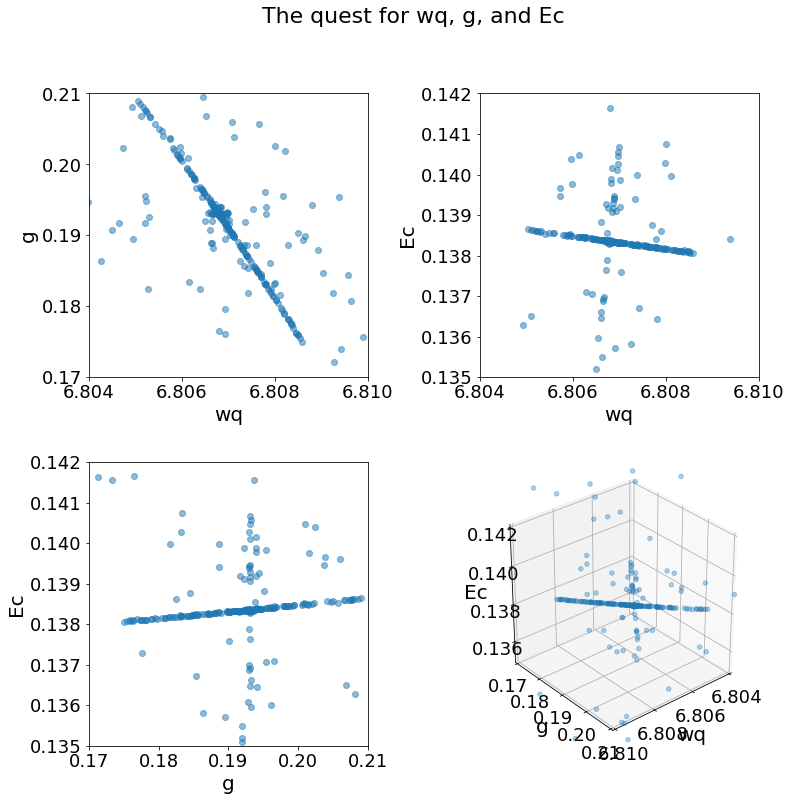

In [179]:
# TODO: assign colour or size to cost

plt.subplots(1, 1, figsize=(12,12))
plt.suptitle("The quest for wq, g, and Ec")

plt.subplot(2, 2, 1)
plt.scatter(fitspace[0], fitspace[1]/10, alpha=0.5)
plt.xlim([6.804, 6.81])
plt.ylim([0.17, 0.21])
plt.xlabel("wq")
plt.ylabel("g")

plt.subplot(2, 2, 2)
plt.scatter(fitspace[0], fitspace[2]/10, alpha=0.5)
plt.xlim([6.804, 6.81])
plt.ylim([0.135, 0.142])
plt.xlabel("wq")
plt.ylabel("Ec")

plt.subplot(2, 2, 3)
plt.scatter(fitspace[1]/10, fitspace[2]/10, alpha=0.5)
plt.xlim([0.17, 0.21])
plt.ylim([0.135, 0.142])
# plt.xlim([0.19, 0.20])
# plt.ylim([0.135, 0.142])
plt.xlabel("g")
plt.ylabel("Ec")

plt.subplot(2, 2, 4, projection='3d')
ax = plt.gca()
ax.scatter(fitspace[0], fitspace[1]/10, fitspace[2]/10)
ax.set_xlim([6.804, 6.81])
ax.set_ylim([0.17, 0.21])
ax.set_zlim([0.135, 0.142])
ax.set_xlabel("wq")
ax.set_ylabel("g")
ax.set_zlabel("Ec")
ax.view_init(30, 50)

plt.subplots_adjust(wspace=0.4)
plt.subplots_adjust(hspace=0.3)